In [1]:
%matplotlib inline

# Can I detect and predict facial keypoints?
(or how to deal with images)

My project for the remote course "Machine Learning" at SoftUni

tuitor: Yordan Darakchiev 

august - november 2022

**Abstract**

Based on a [kaggle competition set]('www.kaggle.com/competitions/facial-keypoints-detection') I try to demonstrate different techniques of machine lerning. The final goal is to predict 15 facial points on face images. 

Each facial keypoint has two coordinates of grey scaled images.

First of all I explore, preprocess or handle the missing data.

Then I use two models for prediction and do comparison between their results.

## 1. Data processing
### 1.1. Importing nesseccery libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn. preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.svm import LinearSVR

from scipy.spatial import distance_matrix

from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

from sklearn.pipeline import make_pipeline
from scipy.sparse import csr_matrix

### 1.2. Reading and exploaring data

Retrieveing data as pd.DataFrame and taking first view into datasets.

**Train set**:

In [3]:
X_train = pd.read_csv('training.csv')
X_train.shape # (7049, 31)

# Display first 3 rows(observations) transposed
X_train.head(3).T

,0,1,2
left_eye_center_x,66.033564,64.332936,65.057053
left_eye_center_y,39.002274,34.970077,34.909642
right_eye_center_x,30.227008,29.949277,30.903789
right_eye_center_y,36.421678,33.448715,34.909642
left_eye_inner_corner_x,59.582075,58.85617,59.412
left_eye_inner_corner_y,39.647423,35.274349,36.320968
left_eye_outer_corner_x,73.130346,70.722723,70.984421
left_eye_outer_corner_y,39.969997,36.187166,36.320968
right_eye_inner_corner_x,36.356571,36.034723,37.678105
right_eye_inner_corner_y,37.389402,34.361532,36.320968


In [4]:
assert X_train.shape == (7049, 31)

In [5]:
X_train.dtypes

left_eye_center_x            float64
left_eye_center_y            float64
right_eye_center_x           float64
right_eye_center_y           float64
left_eye_inner_corner_x      float64
left_eye_inner_corner_y      float64
left_eye_outer_corner_x      float64
left_eye_outer_corner_y      float64
right_eye_inner_corner_x     float64
right_eye_inner_corner_y     float64
right_eye_outer_corner_x     float64
right_eye_outer_corner_y     float64
left_eyebrow_inner_end_x     float64
left_eyebrow_inner_end_y     float64
left_eyebrow_outer_end_x     float64
left_eyebrow_outer_end_y     float64
right_eyebrow_inner_end_x    float64
right_eyebrow_inner_end_y    float64
right_eyebrow_outer_end_x    float64
right_eyebrow_outer_end_y    float64
nose_tip_x                   float64
nose_tip_y                   float64
mouth_left_corner_x          float64
mouth_left_corner_y          float64
mouth_right_corner_x         float64
mouth_right_corner_y         float64
mouth_center_top_lip_x       float64
m

All features are numerical(floats) and only the column *'Image'* is type object.

We need to convert the cells of the this column from strings to integers and reshape each cell to image size: $96$ x $96$.

Finally we create a new column with numerical numbers: *'Num_Image'*

In [6]:
# 1. split the string to separate substrings
split_image = [(cell.split(' ')) for cell in X_train.Image]

# 2. convert the elements of the cells into type(int) and reshape each cell  
for i in range(len(split_image)):
    for j in range(len(split_image[i])):
       split_image[i][j] = int(split_image[i][j])
    
    split_image[i] = np.array(split_image[i]).reshape(96, 96)

# 3. save as new column
X_train['Num_Image'] = split_image   

In [7]:
assert type(split_image[0]) == np.ndarray
assert split_image[0].shape == (96, 96)
assert len(split_image) == X_train.Image.size

Assertion checks are passed.

But to check if everithing is okey, let's display some random images from the new column 'Num_Image'.

In [8]:
# number of images to display:
num_images = 3

def print_image(df_column: pd.Series):

    '''It displays the images of random cells
    
    Parameters:
    df_column:      feature of pd.DataFrame or pd.Series
    '''

    # Generating a list with indicies of random cells:
    rand_inx = np.random.randint(0, len(X_train), num_images, dtype='uint16')
    
    for i in range(num_images):

        plt.subplot(1, num_images, i+1)
        plt.imshow(X_train.at[rand_inx[i], df_column.name], cmap= 'inferno')

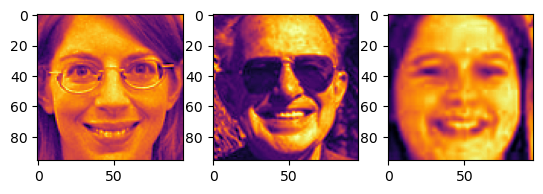

In [9]:
print_image( X_train.Num_Image)
# X_train.Num_Image.name

**Test set**:

In [10]:
X_test = pd.read_csv('test.csv')
X_test.shape # (1783, 2)

(1783, 2)

In [11]:
X_test.head(3)

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...


In [12]:
X_test.dtypes

ImageId     int64
Image      object
dtype: object

Again we need to convert the 'Image' column into 'int' and reshape into $96$ x $96$, since column 'ImageId' is numerical. 

In [13]:
X_test['Num_Image'] = [np.array(x.split(' ')).reshape(96, 96).astype('uint16') for x in X_test.Image]

In [14]:
X_test.dtypes

ImageId       int64
Image        object
Num_Image    object
dtype: object

In [15]:
assert type(X_test['Num_Image']) == pd.Series
assert type(X_test['Num_Image'][0]) == np.ndarray
assert X_test['Num_Image'][0].shape == (96, 96)
assert X_test['Num_Image'].shape == X_test.Image.shape

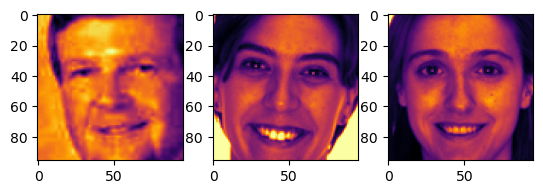

In [16]:
# check out with 3 randomm images if the new column 'Num_Image' is okey:
num_images = 3
print_image( X_test['Num_Image'])

In [17]:
id_lookup_table = pd.read_csv('IdLookupTable.csv')
id_lookup_table

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN
...,...,...,...,...
27119,27120,1783,right_eye_center_y,NaN
27120,27121,1783,nose_tip_x,NaN
27121,27122,1783,nose_tip_y,NaN
27122,27123,1783,mouth_center_bottom_lip_x,NaN


In [18]:
id_lookup_table.dtypes

RowId            int64
ImageId          int64
FeatureName     object
Location       float64
dtype: object

Now as we could see that a number of CSV files are read in above cells. Let's get better understanding what each file contains.

<span style="color:darkblue">__*Training File:*__</span>

**training.csv:** This file contains training data. Last column of this file named Image contains image data. Rest 
of the columns ends <kbd>_x</kbd> or <kbd>_y</kbd> coordinate values values for different keypoints. E.g.: First 
two columns *left_eye_center_x*, *left_eye_center_y* denote $x$ and $y$ coordinates of center point of *left eye*.

Also, column Image contains image was a string of numbers, separated by spaces. Then we have 
converted this image to 2D numpy array so that we could process it as actual image.

<span style="color:darkblue">__*Testing Files:*__</span>

Rest of the files will be used to make submissions. Lets understand each one in detail:

**test.csv:** This file contains only two columns ImageId, Image. Again, here the images were represented as string 
of numbers and then converted to 2D numpy arrays. We need to make predictions of keypoints for each image 
present in this file.

**IdLookupTable.csv:** For each image in test we do not need to predict all keypoints. What keypoints are required 
for each image are mentioned in this file. This file has got 4 columns: *RowId*, *ImageId*, *FeatureName*, 
*Location*. So we need to extract Location for specific FeatureName for each ImageId.

**SampleSubmission.csv:** This is a final submission file into a kaggle-competition. We'll not use it for our 
project work.



### 1.3. Handling missing values in the data

First we analyze how much are the missing values by features. 

We see that there is very big gap by distribution of missing values. The following have less then 15:

 - mouth_center_bottom_lip
 - nose_tip
 - left_eye_center 
 - right_eye_center

The rest features missed almost 5000.  

In [19]:
X_train.isna().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

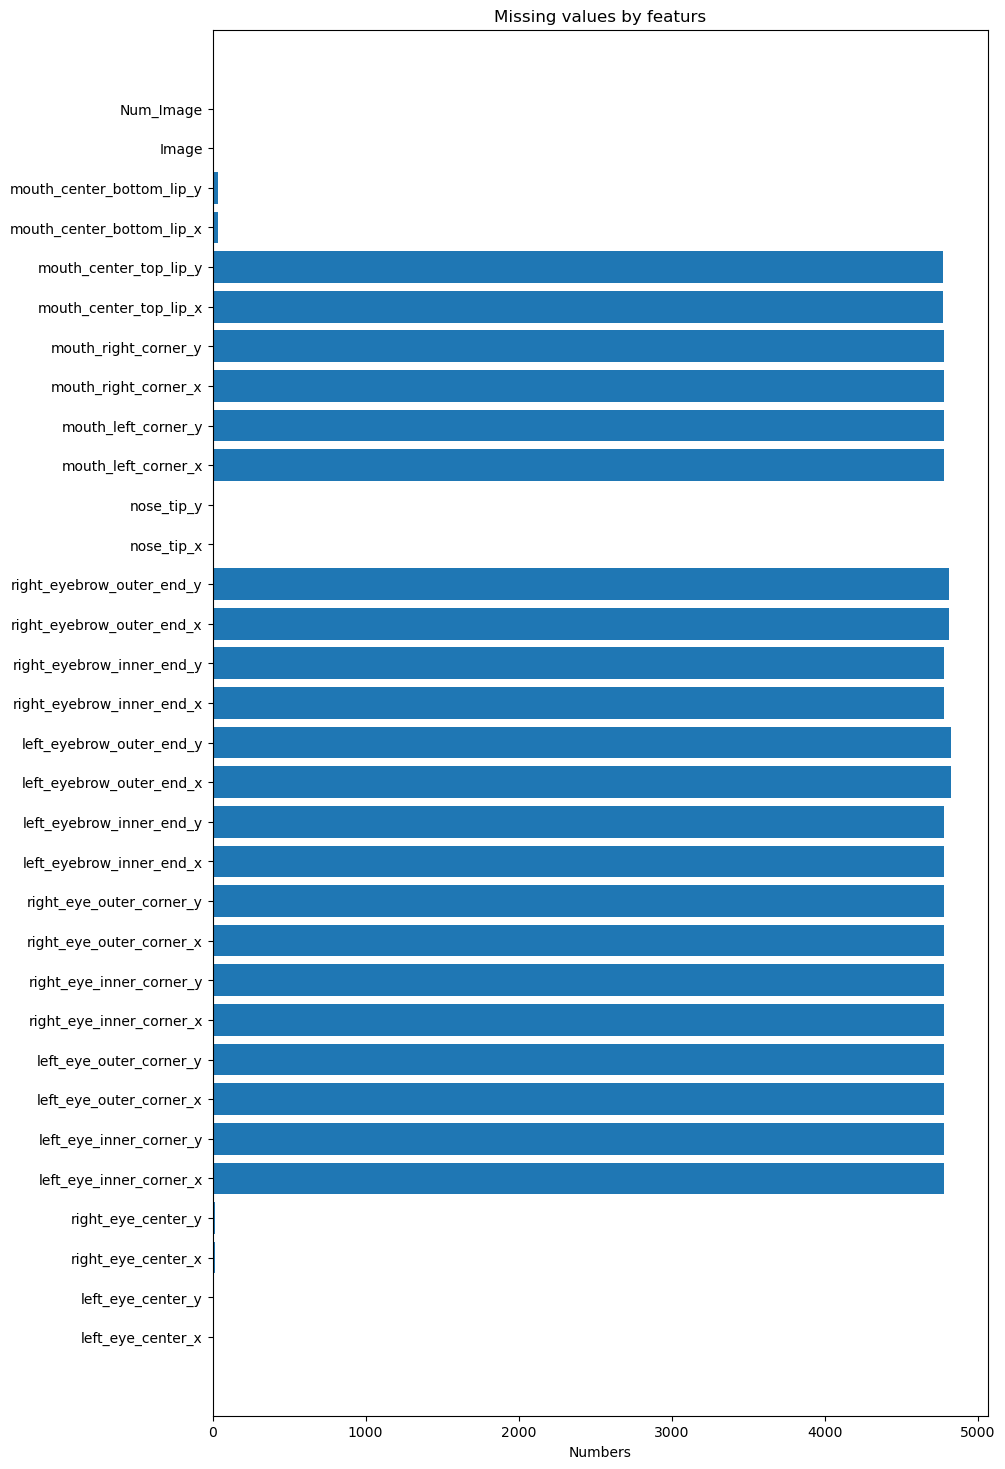

In [20]:
plt.figure(figsize=(10, 18))

plt.barh(X_train.isna().sum().index, (X_train.isna().sum().values))

plt.xlabel('Numbers')
plt.title( 'Missing values by featurs')

plt.show()

Filling the missing with last observed value and compare how works '.fillina(method="ffill")' with a row.

In [21]:
# before
columns_with_nans = [x for x in X_train.columns if X_train.isna().sum().loc[x] != 0]
X_train.loc[1686: 1688, columns_with_nans]

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
1686,65.122098,36.396540,31.040735,37.985295,57.537073,37.395918,71.842020,38.418872,38.472010,38.907798,...,14.570618,31.274280,65.167833,75.855061,37.012677,77.215894,53.506906,72.030653,52.357237,76.817029
1687,NaN,NaN,NaN,NaN,57.931068,40.808627,73.232712,44.910035,NaN,NaN,...,19.365442,23.906166,54.595918,74.511943,24.118659,68.652754,39.136317,71.487238,37.405514,75.520178
1688,64.732263,38.099388,29.076790,38.230185,57.852300,39.485844,74.175863,38.622579,40.299239,40.113673,...,13.508442,32.109091,63.814675,74.988312,32.466623,75.666234,51.074415,77.746753,51.167922,78.611688


In [22]:
columns_with_nans = [x for x in X_train.columns if X_train.isna().sum().loc[x] != 0]
X_train_filled = X_train.fillna(method='ffill')

# after 
X_train_filled.loc[1686: 1688, columns_with_nans]

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
1686,65.122098,36.396540,31.040735,37.985295,57.537073,37.395918,71.842020,38.418872,38.472010,38.907798,...,14.570618,31.274280,65.167833,75.855061,37.012677,77.215894,53.506906,72.030653,52.357237,76.817029
1687,65.122098,36.396540,31.040735,37.985295,57.931068,40.808627,73.232712,44.910035,38.472010,38.907798,...,19.365442,23.906166,54.595918,74.511943,24.118659,68.652754,39.136317,71.487238,37.405514,75.520178
1688,64.732263,38.099388,29.076790,38.230185,57.852300,39.485844,74.175863,38.622579,40.299239,40.113673,...,13.508442,32.109091,63.814675,74.988312,32.466623,75.666234,51.074415,77.746753,51.167922,78.611688


This method is not bad but not very good because the filled coordinats are not correct adjusted and the keypoints will be not at the correct place. 

**A more precise approach:**

We try to do some better approximation with avarage distances to *real existing keypoints* in the dataset.

As *real existing keypoints* we use:

 - the coordinates of the features with minimum missing values. 

Then we'll compute the **average distance** between *a real existing keypoint* and the targeted missing keypoint.

*Note:* there are even better solution for this specific case we don't apply in the current project. The idea is to take more distances between existing keypoints.

Here we create *2 distinguished areas* in order of the *real existing keypoints* with most given coordinates:

- month area
- eye area

First we drop all missing values in dataset. 

Now we compute the following **average distance** for the missing keypoints:

In [23]:
# Dropping all missing values
X_train_dropna = X_train.dropna() # 2140 rows × 32 columns

# Avarage distance MOUTH AREA

def avrg_dropped_distance_from_mouth_to (feature_with_nans: str):
    '''Computes the avarage distance in the "mounth area" using 'dropped' dataset
    
    Parameters:
    feature_with_nans(str):  the names of the feature with many NaN
                    name can be one of {'mouth_left_corner', 'mouth_right_corner' or 'mouth_center_top_lip'} 
    Return:
    av_distance(float):   avarage distance rounded till 5 signs             
    '''
    avrg_m_centr_bottom_lip_x = X_train_dropna['mouth_center_bottom_lip_x'].mean()
    # 48.1496539871852
    avrg_m_centr_bottom_lip_y = X_train_dropna['mouth_center_bottom_lip_y'].mean()
    # 82.63041245065179
    
    av_missing_x = X_train_dropna[feature_with_nans + '_x'].mean()
    av_missing_y = X_train_dropna[feature_with_nans + '_y'].mean()

    # Difference between coordinates of 'mouth_center_bottom_lip' and 'feature_with_nans'
        
    # Extrapolating new avarage coordinates


    av_distance=distance_matrix([[avrg_m_centr_bottom_lip_x, avrg_m_centr_bottom_lip_y]],[[av_missing_x, av_missing_y]])[0][0]
    
    return round(av_distance, 5)


In [24]:
avrg_dropped_distance_from_mouth_to('mouth_left_corner')
# 16.69191

avrg_dropped_distance_from_mouth_to('mouth_right_corner')
# 16.51376

avrg_dropped_distance_from_mouth_to('mouth_center_top_lip')
#  9.94952

(9.94952, 0.07, 9.95)

(9.94952, 0.07, 9.95)

In this study we'll use the mean value of each feature to replace the missing values.

For the porpouse we'll prepare a dictionary.

In [25]:
columns_with_nans = [x for x in X_train.columns if X_train.isna().sum().loc[x] != 0]

# Creating a dict with mean values by columns
means_by_features = dict(X_train.drop(columns=['Image', 'Num_Image']).mean(axis=0, skipna= True))

# Filling NaN with mean value of each column

X_train_fm = X_train.fillna(value = means_by_features)
 
# X_train_fm.shape -> 7049 rows × 32 columns

In [26]:
# Check out if there are still missing values in 'X_train_fm'

assert [value for value in X_train_fm.isna().any().values if value == True] == []

## 2. Modeling 
### 2.1. Preparing data for modeling

Lets show first some random images with keypoints.

In [27]:
# First divide in X(testing data) and in y(predicting targets)
# Targets are the keypoints coordinates and data set are the images

X = X_train_fm['Num_Image']
y = X_train_fm.drop(columns=['Image','Num_Image'])

In [28]:
X[0].shape, y.shape

((96, 96), (7049, 30))

Now we split in to trainig sets and validation sets:

In [29]:
X_training, X_val, y_training, y_val = train_test_split(X, y, test_size = 0.90, shuffle=False)

# Check shapes
X_training.shape, X_val.shape, y_training.shape, y_val.shape

((704,), (6345,), (704, 30), (6345, 30))

In [30]:
# reshape an image size from (96, 96) to (9216,) and put in a new list. 9216 = 96 * 96

def reshape_images (list_with_images):
    return [img.reshape((96*96,)) for img in list_with_images]
# check the size of one reshaped image

X_training = reshape_images(X_training)



#### 2.2 **Linear regression**

In [31]:
# Test with 1000 images only
# Modeling of a test for the first 1000 images because of time reasons

X_1000 = []
# Reshape and slice first 1000 rows of 'X'
for i in range(1000): # Use only 1000 images first
  X_1000.append(np.array(X[i]).reshape(96 * 96,))

# slice first 1000 rows of 'y'
y_1000 = y.loc[:999]
y_1000

my_linr_left_eye_center_y = LinearRegression()

my_linr_left_eye_center_y.fit(X_1000, y_1000[y.columns[1]].values)

LinearRegression()

In [32]:
# Simple evaluation of model -> check at one pixel with the predicted coordinate
X_all = []

# reshape the image size from (96, 96) to (9216,) and put in a new list. 9216 = 96 * 96
for i in range(X.size):
  X_all.append(np.array(X[i]).reshape(96 * 96,))

# check the size of one reshaped image
X_all[78].size
print("prediction:", my_linr_left_eye_center_y.predict([X_all[2000]]))
print("real", y.at[2000, y.columns[1]])

prediction: [36.58383076]
real 37.3845694373


Difference here is 1 pixel what is not bad at the biginning.

:)

### 2.3. Now we'll test the **MulitiLinearRegressor**

In [33]:
from sklearn.linear_model import Ridge

mo_regr = MultiOutputRegressor(Ridge(random_state=123)).fit(X_training, y_training)

In [34]:
# Comparision between predicted and real coordinates of image at row 704

print(mo_regr.predict([reshape_images(X_val)[704]]))
print(y_val.loc[704].values)


[[68.11239167 35.77284786 28.95884595 33.86454337 61.32066903 36.26024115
  74.01017166 36.15444091 35.86666059 34.78555446 20.62003926 34.90465714
  54.38847906 26.41271575 80.24521531 26.94464289 32.72210184 22.99457898
  13.73297595 27.22115927 44.35182296 56.12731563 61.02165246 78.69803306
  33.9004967  79.94902137 46.58664877 71.25478459 45.67281167 88.09142723]]
[65.61814925 39.2953791  28.9038806  37.04102687 59.82089552 40.2615403
 71.73707463 41.22762985 34.37874627 38.32921791 23.10734328 38.00711642
 56.60059701 29.95586866 80.43223881 32.53225075 37.27737313 27.70151642
 15.69958209 28.02354627 46.86662687 59.74638806 57.88871642 83.73850746
 31.4801194  82.7720597  46.61659701 77.29719403 46.29492537 91.78961194]


Model evaluation with **cross-validation**

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(mo_regr, X_training, y_training, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = abs(n_scores)
# summarize performance
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: 1.066 (0.047)


Combination with **Linear SVR** 

In [36]:

# define base model
svr_model = LinearSVR()
# define the direct multioutput wrapper model
wrapper = MultiOutputRegressor(svr_model)
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(wrapper, X_training, y_training, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = np.absolute(n_scores)
# summarize performance
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: 4.613 (0.398)


In [37]:
n_scores

array([4.70584942, 4.40639525, 4.64805403, 5.22507943, 4.19514025,
       5.37253362, 3.88902713, 4.79358543, 4.3524535 , 4.51482495,
       4.78633431, 4.99114621, 4.60799512, 4.75768107, 4.22621695,
       4.34380714, 4.44313751, 4.22013038, 5.29014602, 4.17114126,
       3.99239833, 4.35596605, 4.94947018, 3.98858895, 4.8944599 ,
       5.19978681, 4.47432829, 4.88090306, 5.0783421 , 4.64764289])

In [58]:
# mo_regr.n_features_in_  # 9216

# len(mo_regr.estimators_)  # 30
#   print(mo_regr.estimators_)
#   [Ridge(random_state=123),
#   Ridge(random_state=123),
#   .....
#   Ridge(random_state=123)]  -> total 30 

## 3.Conclusion 

The comparison between the both Models: 
 1. MultiOutputRegressor(**mo_regr**) and  
 2. Combination(**wrapper**) between MultiOutputRegressor and SVM-method: much slower and bigger mistake( worse results) 
 
The 1.Model shows:
* better results MAE: 1.066 (std: 0.047) compared to 2.Model MAE: 4.613 (std: 0.398)  
* it is faster: 1min 44.8sec to 159min 44.1sec 